## Предсказание оттока кадров


### Цель:

Построить модель, которая точнее всего предскажет вероятность ухода сотрудника. Это нужно для того, чтобы предотвратить потерю сотрудников и позволить отделу кадров вовремя начать меры по удержанию тех, кого модель определит в "группу риска" (потенциально ушедшие сотрудники).



---
### Используемые модели из **sklearn**:

1. Logistic Regression

2. Random Forest Classifier



### Из **gxboost**

3. GXBoostClassifier


### Какие данные есть?



Датасет содержит 10 колонок:

*   **left**: таргет - yшел сотрудник или нет (1/0)
*   **satisfaction_level**:  уровень удовлетворенности сотрудника (в процентах по результатам анкетирования)   
*   **last_evaluation**:  балл за последнюю "аттестацию" (в процентах)   
*   **number_project**: число проектов          
*   **average_montly_hours**: среднее количество часов работы в месяц  
*   **time_spend_company**: время работы в компании (лет)   
*   **Work_accident**: были ли несчастные случаи (1/0)                              
*   **promotion_last_5years**: были ли повышения за последдние 5 лет(1/0)   
*   **sales**:  отдел               
*   **salary**: заработная плата (высокая, средняя или низкая)


---











### Краткий обзор итогов и выводов:

1. **Выводы после исследовательского анализа данных (EDA):**

   * Данные не сбалансированы. Пропорции ушедших и не ушедших - 24% и 76% соответственно.
   * Какие факторы могут быть связаны с решением не покидать компанию? Более высокая зарплата, недавнее повышение, работа в определенных отделах, где текучка ниже (Менеджмент и R&D).  Странно, но факт несчастных случаев не увеличивает вероятность ухода из компании.
   * Те, кто ушел, указывали в опросниках более низкий уровень удовлетворенности. Они также работали, в среднем, больше часов в месяц и брали больше проектов на себя.
   

2. **Выводы после построения моделей-классификаторов**:

   * Самая важная метрика для данных моделей - Recall, потому что нам важно минимизировать число тех, кто ложно будет определен в группу "неуходящих".

   * В самом конце блокнота - совдная таблица со всеми моделями и основными метриками.

   * Из трех моделей лучшие результаты - у Random Forest. Accuracy - около 99%, Recall - около 96%.

   * Такой точности модель добивается, учитывая главным образом всего лишь 4 параметра - Уровень удовлетворенности, последнюю оценку, количество часов в месяц, общее время работы в компании.

   * Эти же четыра параметра (фичи) - самые важные и для XGBoost модели.


3. **Прикладной вывод**:
Особенное внимание нужно уделять мониторингу тех сотрудников, которые:
   * перерабатывают,
   * работают в компании больше 3-х лет (до 3-х мало кто покидал компанию, что видно на боксплоте).
   * дают низкие оценки уровню своей удовлетворенности в опросниках.
   * получают высокие оценки за аттестацию (следовательно, имеют больше шансов получить работу и в другом месте).
   

### План:

1. Импорт библиотек и первичная чистка данных (проверка пропущенных значений, названий колонок, типов данных, адекватного содержания).

2. Исследовательский обзор данных и визуализация, первые наблюдения и инсайты.

3. Подготовка к моделированию.

4. Моделирование.

5. Сводная таблица со всеми моделями и основными метриками их успешности.

## 1. Импорт
### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix







### Импорт данных и их первичная подготовка

In [2]:
df = pd.read_csv('/kaggle/input/hr-dataset/HR_Dataset.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df.shape

(14999, 10)

14999 строк (наблюдений) и 10 колонок (переменных).

In [4]:
df.rename(columns={'Departments ':'department'}, inplace=True)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# поменять порядок колонок

print(df.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')


In [6]:
df = df[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 
       'promotion_last_5years', 'department', 'salary', 'left']]

In [7]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [8]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
promotion_last_5years    0
department               0
salary                   0
left                     0
dtype: int64

Нет пропущенных данных.

## 2. EDA

### 2. 1 Исследование категориальных переменных

#### Выводы из представленных ниже графиков и таблиц:

* Примерно 24% людей из этой базы даных ушли (то есть данные не сбалансированы).

* С 14% опрошенных случался несчастный случай на работе.

* Только 2% из опрошенных получали повышение в последние 5 лет.

* Больше всего человек работает в отделах продаж, техническом отделе и поддержке.

* Высокая зарплата -  только у 8% работников.

Значения колонки "left":
0    11428
1     3571
Name: left, dtype: int64

Нормализованное распределение значений
0    0.761917
1    0.238083
Name: left, dtype: float64



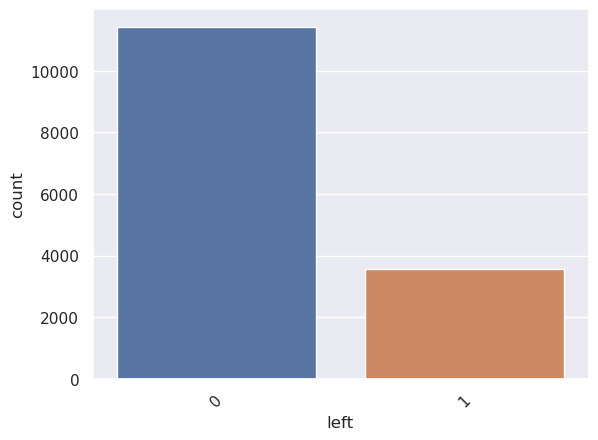

Значения колонки "Work_accident":
0    12830
1     2169
Name: Work_accident, dtype: int64

Нормализованное распределение значений
0    0.85539
1    0.14461
Name: Work_accident, dtype: float64



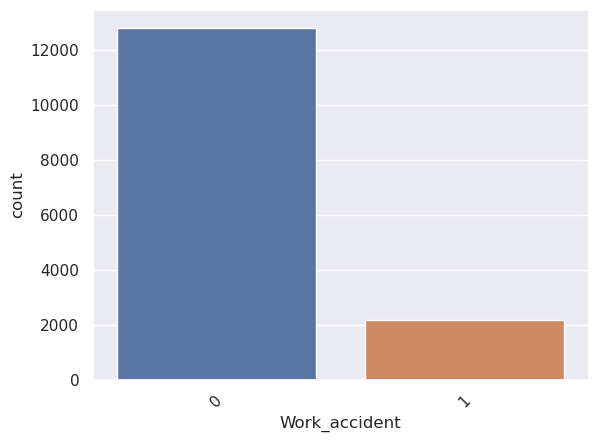

Значения колонки "promotion_last_5years":
0    14680
1      319
Name: promotion_last_5years, dtype: int64

Нормализованное распределение значений
0    0.978732
1    0.021268
Name: promotion_last_5years, dtype: float64



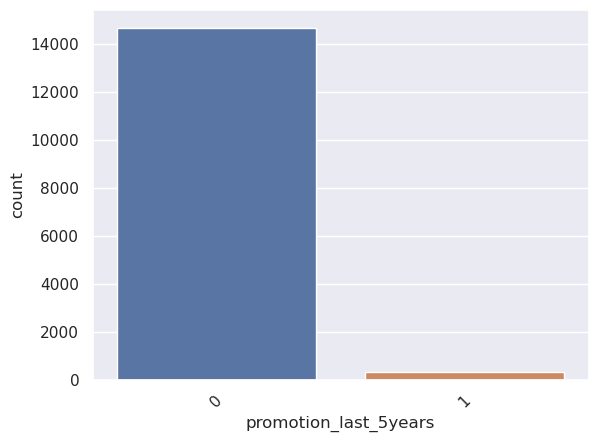

Значения колонки "department":
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

Нормализованное распределение значений
sales          0.276018
technical      0.181345
support        0.148610
IT             0.081805
product_mng    0.060137
marketing      0.057204
RandD          0.052470
accounting     0.051137
hr             0.049270
management     0.042003
Name: department, dtype: float64



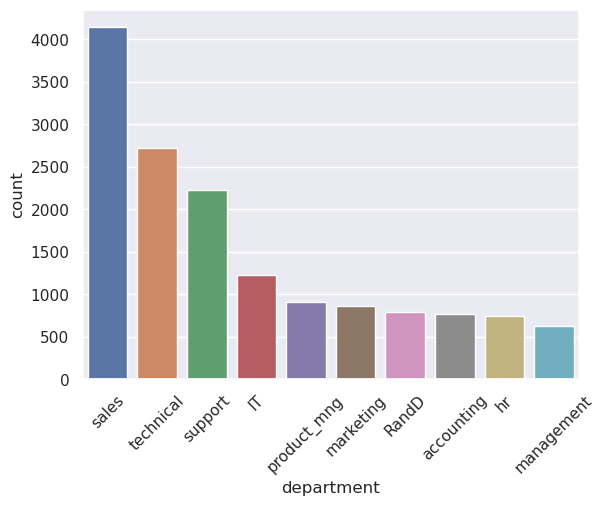

Значения колонки "salary":
low       7316
medium    6446
high      1237
Name: salary, dtype: int64

Нормализованное распределение значений
low       0.487766
medium    0.429762
high      0.082472
Name: salary, dtype: float64



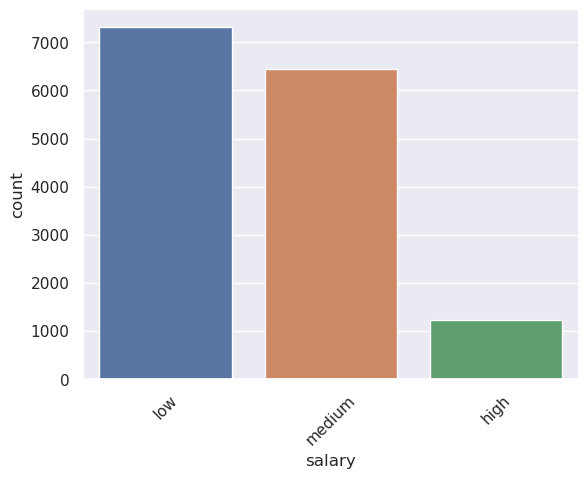

In [9]:
cat_vars =['left', 'Work_accident', 'promotion_last_5years', 'department', 'salary']

for i in cat_vars:
  print(f'Значения колонки "{i}":')
  print(df[i].value_counts())
  print()
  print("Нормализованное распределение значений")
  print(df[i].value_counts(normalize=True))
  print()
  sns.countplot(x=df[i], order= df[i].value_counts().index)
  plt.xticks(rotation=45)
  plt.show()

### 2. 2 Связь категориальных переменных и нашего таргета

Выводы:

* опыт несчастных случаев не ассоциируется с более высокой вероятностью ухода.

*  меньший % тех, кого повышали в последние 5 лет, ушли из компании (в сравнении с теми, кого не повышали).

* больше всего людей ушли из отдела продаж (28% от всех ушедших рабтали именно в этом отделе). Меньше всго - из отделов менеджмента и R&D (примерно 3 %  соответсвенно от всех ушидних в каждом из этих двух отделе).

* высокая зарплата ассоциируется с более низким процентов ушедших.

In [10]:
ind_cat_vars = ['Work_accident', 'promotion_last_5years', 'department', 'salary']

for i in ind_cat_vars:
  print(f'"{i}" vs "left"')
  print()
  print(pd.crosstab(df[i], df['left'], normalize='index'))
  print()
  print()

"Work_accident" vs "left"

left                  0         1
Work_accident                    
0              0.734840  0.265160
1              0.922084  0.077916


"promotion_last_5years" vs "left"

left                          0         1
promotion_last_5years                    
0                      0.758038  0.241962
1                      0.940439  0.059561


"department" vs "left"

left                0         1
department                     
IT           0.777506  0.222494
RandD        0.846252  0.153748
accounting   0.734029  0.265971
hr           0.709066  0.290934
management   0.855556  0.144444
marketing    0.763403  0.236597
product_mng  0.780488  0.219512
sales        0.755072  0.244928
support      0.751009  0.248991
technical    0.743750  0.256250


"salary" vs "left"

left           0         1
salary                    
high    0.933711  0.066289
low     0.703116  0.296884
medium  0.795687  0.204313




In [11]:
pd.crosstab(df['department'], df['left'], normalize='columns')

left,0,1
department,,
IT,0.083479,0.076449
RandD,0.058278,0.033884
accounting,0.049265,0.057127
hr,0.045852,0.060207
management,0.047165,0.025483
marketing,0.057315,0.056847
product_mng,0.061603,0.055447
sales,0.273539,0.283954
support,0.146482,0.155419


In [12]:
pd.crosstab(df['salary'], df['left'], normalize='columns')

left,0,1
salary,,
high,0.101068,0.022963
low,0.450123,0.608233
medium,0.448810,0.368804


## 2. 3 Исследование числовых переменных

#### **Выводы** по графикам и таблицаа ниже:

* Пoловина людей оценивают свою удовллетворенность радботой в компании не выше, чем на 64%.

* Большинство работало над 3-4 проектами.

* Почти половина работников работает более 200 часов в месяц.





In [13]:
num_vars = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company' ]

In [14]:
df[num_vars].describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233
std,0.248631,0.171169,1.232592,49.943099,1.460136
min,0.090000,0.360000,2.000000,96.000000,2.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000


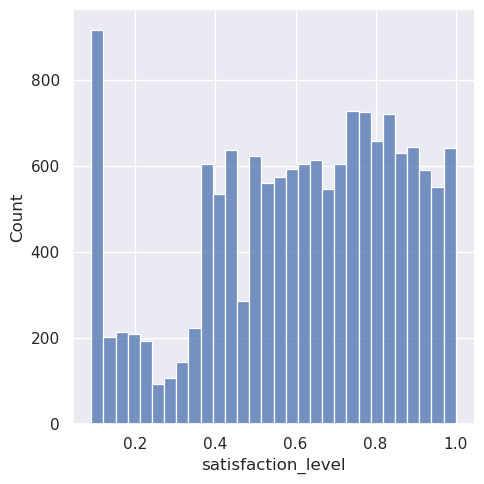

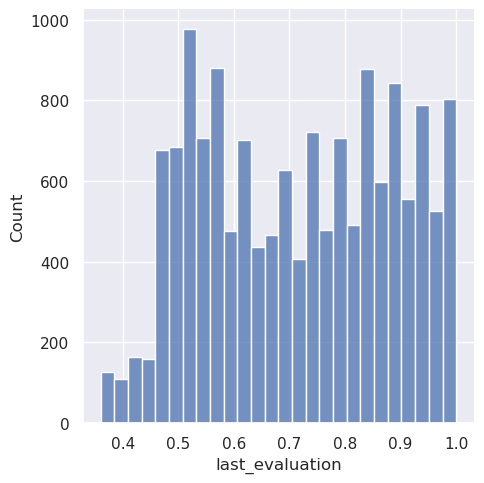

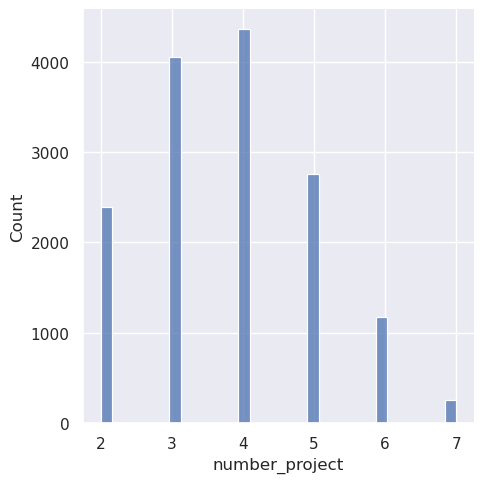

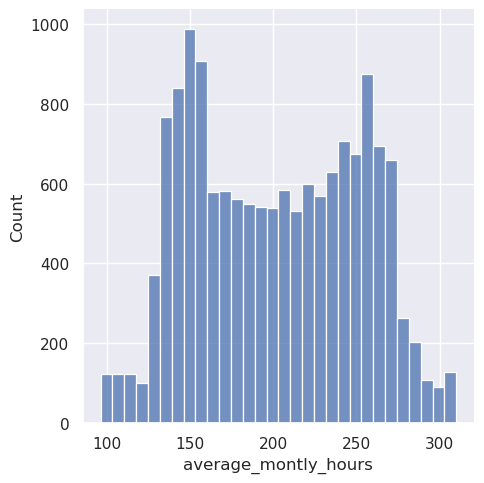

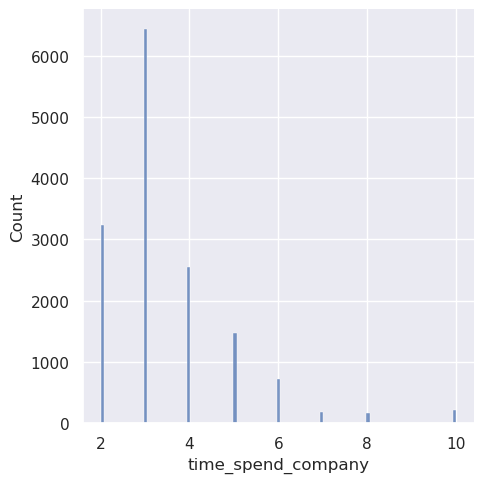

In [15]:
for i in num_vars:
  sns.displot(df[i])
  plt.show()

In [16]:
#рабочeе время более 200 часов

over200 = df[df['average_montly_hours'] > 200].shape[0]
print(over200)
print(over200/df.shape[0]*100)

7475
49.8366557770518


### 2. 4 Связь числовых переменных и таргета

#### Выводы:

* В среднем, покинувшие компанию оценивали свою удовлетворенность ниже в опросах;

* 75 % из тех, кто не ушел, не брали более 4х проектов. И почти никто из них не брал более 5 проектов. 75 % покинувших работали с 6 проектами.

* В среднем, покинувшие компанию работали дольше.

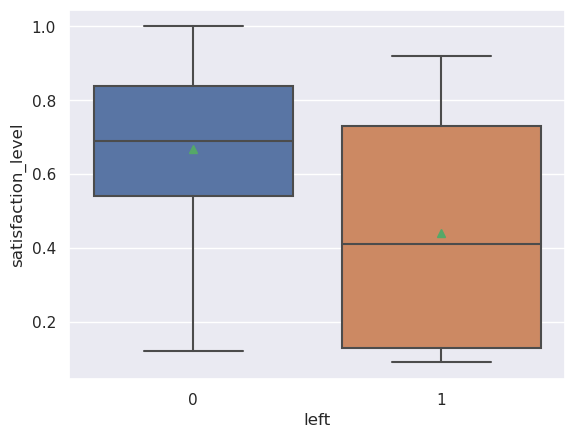

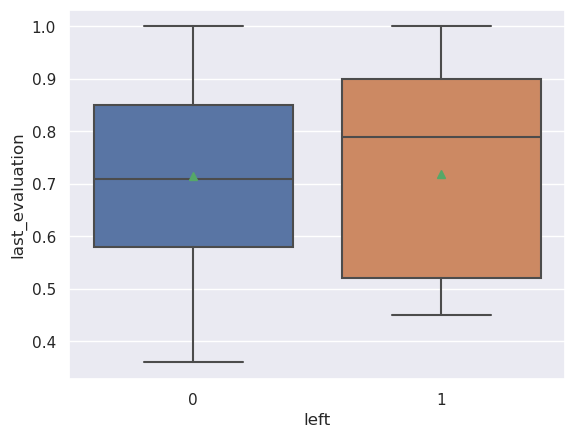

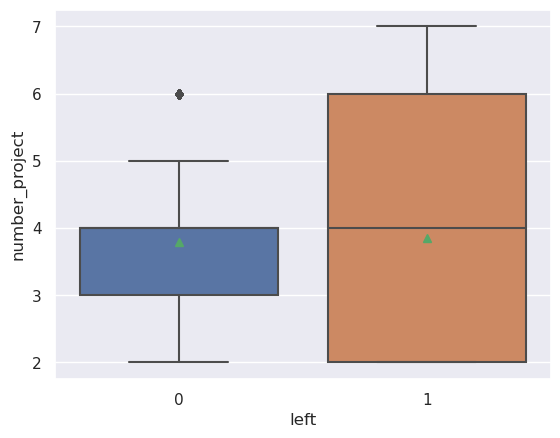

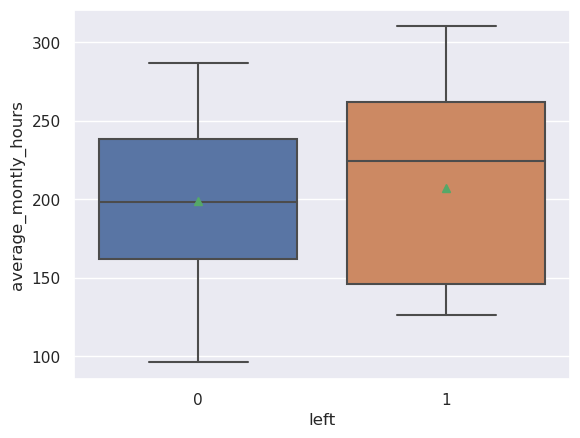

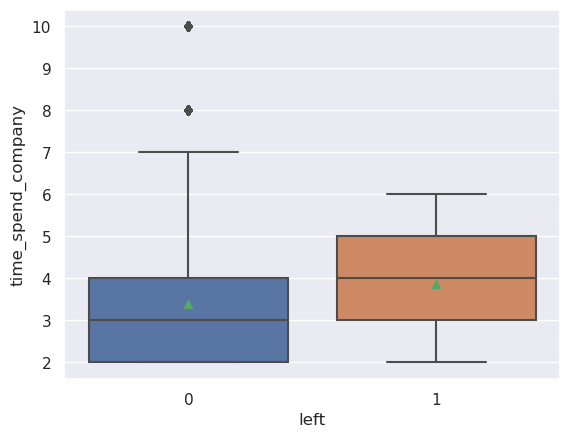

In [17]:
for i in num_vars:
  sns.boxplot(x=df['left'], y=df[i], showmeans=True)
  plt.show()

## 2.5 Корреляция

<Axes: >

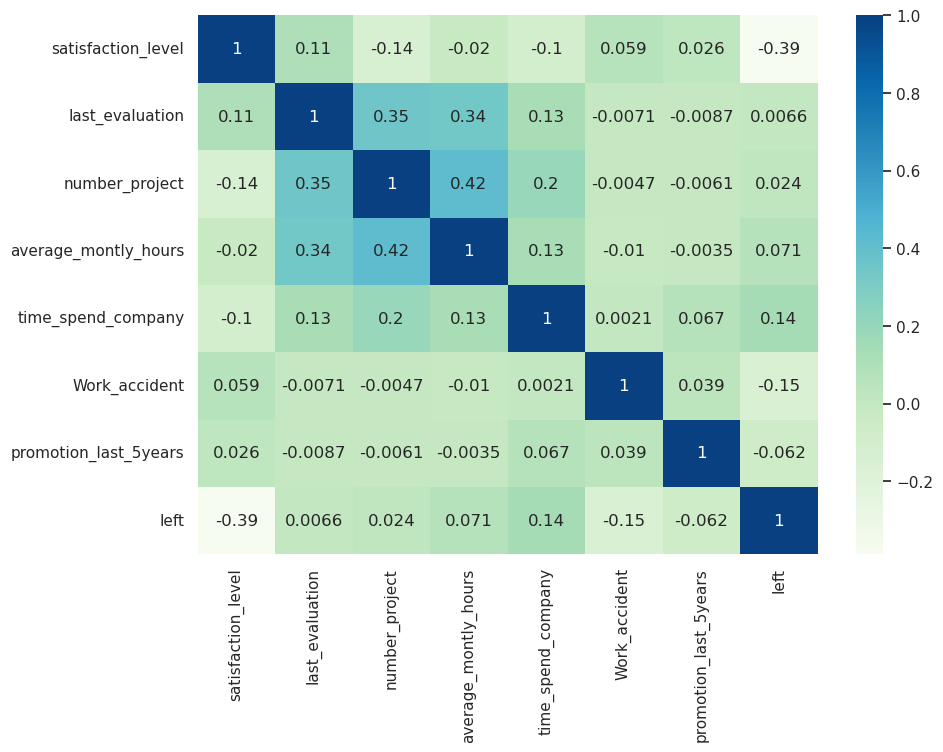

In [18]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="GnBu")

**Умеренная позитивная** коррреляция замечена между:

* часами работы в месяц И количеством проектов (что предсказуемо)

**Умеренная негативная** - между:

* между оценкой удовлетворренности и финальным статусом (покинул или нет)

In [19]:
#sns.pairplot(df, hue='left')

## 3. Подготовка данных

### 3. 1 Проверка на Мультиколлинеарность

In [20]:
variables = df[num_vars]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,6.128774,satisfaction_level
1,19.983386,last_evaluation
2,13.787481,number_project
3,18.915832,average_montly_hours
4,6.509067,time_spend_company


In [21]:
variables = df[['satisfaction_level',  
       'average_montly_hours', 'time_spend_company' ]]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,5.245416,satisfaction_level
1,8.723839,average_montly_hours
2,5.781363,time_spend_company


Для ML моделей мультиколлинеарность не так важна, но мы можем убрать колонку (number_project), чтобы все равно избежать ее и уменьшить количество фитч. Она коррелируют друг с другомм и еще другой колонкой. И слабо коррелируют с таргетом. Last_evaluation кажется более важной (что можно проверить в модели Random Forest позднее). 

In [22]:
#drop

df1 = df.drop([ 'number_project'], axis=1)

In [23]:
df1.head()

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,157,3,0,0,sales,low,1
1,0.80,0.86,262,6,0,0,sales,medium,1
2,0.11,0.88,272,4,0,0,sales,medium,1
3,0.72,0.87,223,5,0,0,sales,low,1
4,0.37,0.52,159,3,0,0,sales,low,1


### Фиктивные пременные

In [24]:
#Фиктивные переменные

df2 = pd.get_dummies(df1, drop_first=True)
df2.head()

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,157,3,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,262,6,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,272,4,0,0,1,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,223,5,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,159,3,0,0,1,0,0,0,0,0,0,1,0,0,1,0


In [25]:
X = df2.drop('left', axis=1)
y = df2['left']

In [26]:
#train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)


### Комментарии к моделям

Нам важно **минимизировать False Negatives**, то есть количество тех, кто уйдет, хотя модель предсказала, что он не уйдет. Потому что это главная потеря в данном случае. На False Positives будут потрачены лишние ресурсы на удержание, оданко, это не так страшно, как потеря сотрудника (когда модель "проглядела").

Следовательно, самая главная метрика для нас - **Recall**.

## Логистическая регрессия (модель1)

---



In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

log_reg = LogisticRegression()
log_reg.fit(X_train_sc, y_train)

LogisticRegression()

In [28]:
log_reg.score(X_train_sc, y_train)

0.7734909769757312

In [29]:
log_reg.score(X_test_sc, y_test)

0.7650666666666667

### Матрица Ошибок (Confusion Matrix)

Код визуализации для Матрицы взят из [статьи на Медиуме](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea).

In [30]:
y_pred = log_reg.predict(X_test_sc)

In [31]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2615  175]
 [ 706  254]]


In [32]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
  # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

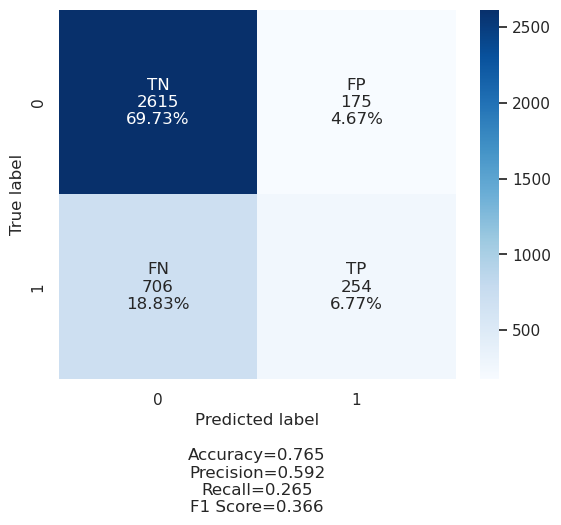

In [33]:
make_confusion_matrix(cm, group_names=["TN", "FP", "FN", "TP"])

### Улучшение модели 


---
Recall очень низкий, можно улучшить, изменив **threshold**.
Код взят из [статьи](https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e).






Text(0, 0.5, 'Precison')

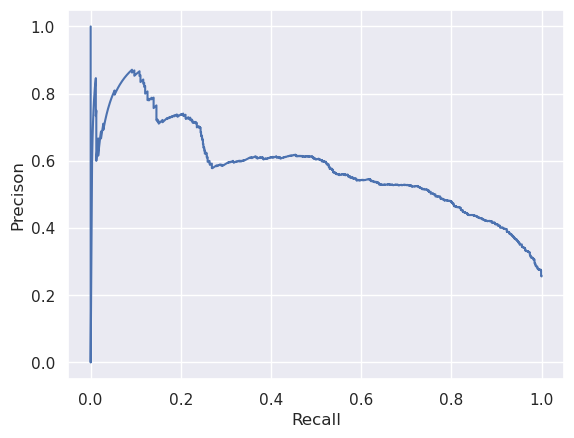

In [34]:
y_pred_prob = log_reg.predict_proba(X_test_sc)[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precison')

Оптимальное наилучшее значение для Recall - 70%.

## Логистическая регрессия с другим порогом





In [35]:
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)

            return y_pred_with_threshold
    
    def threshold_from_desired_recall(self, X, y, desired_recall=0.9):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

        desired_recall_idx = np.argmin(recalls >= desired_recall)
        
        return thresholds[desired_recall_idx], precisions[desired_recall_idx]

    

In [36]:
log_reg_thr = LogisticRegressionWithThreshold()
log_reg_thr.fit(X_train_sc, y_train)

threshold, precision = log_reg_thr.threshold_from_desired_recall(X_train_sc, y_train, 0.70)
threshold, precision

(0.26265288872128956, 0.4883720930232558)

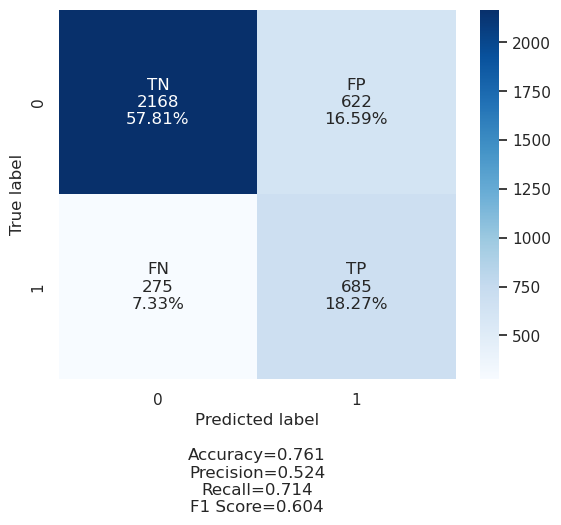

In [37]:
y_pred2 = log_reg_thr.predict(X_test_sc, threshold)
cm_t = confusion_matrix(y_test, y_pred2)
make_confusion_matrix(cm_t, group_names=["TN", "FP", "FN", "TP"])

In [38]:
accuracy  = np.trace(cm_t) / float(np.sum(cm_t))
precision = cm_t[1,1] / sum(cm_t[:,1])
recall    = cm_t[1,1] / sum(cm_t[1,:])
f1_score  = 2*precision*recall / (precision + recall)

logreg_thr_results = pd.DataFrame({"accuracy":[accuracy],  "precision":[precision], 
                            "recall":[recall],  "f1_score":[f1_score]},
                           index=['log_reg'])


logreg_thr_results

,accuracy,precision,recall,f1_score
log_reg,0.7608,0.524101,0.713542,0.604323


## Random Forest (2-ая Модель )

In [39]:

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

1.0

In [40]:
rf.score(X_test, y_test)

0.9901333333333333

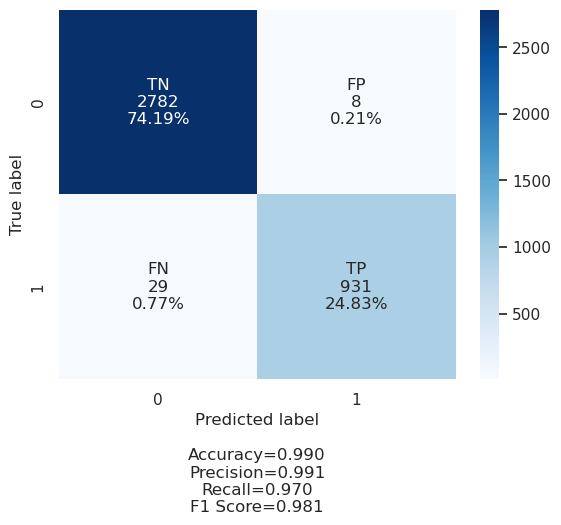

In [41]:
y_pred2 = rf.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)
make_confusion_matrix(cm2,group_names=["TN", "FP", "FN", "TP"])

In [42]:
rf.get_params()

#посмотреть параметры этого RandomForest

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [43]:
# получить список важности разных переменных
importances = list(rf.feature_importances_)


feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for pair in feature_importances:
  print('Переменная: {:20} Ее важность: {}'.format(*pair))


Переменная: satisfaction_level   Ее важность: 0.39
Переменная: time_spend_company   Ее важность: 0.22
Переменная: average_montly_hours Ее важность: 0.19
Переменная: last_evaluation      Ее важность: 0.16
Переменная: Work_accident        Ее важность: 0.01
Переменная: salary_low           Ее важность: 0.01
Переменная: promotion_last_5years Ее важность: 0.0
Переменная: department_RandD     Ее важность: 0.0
Переменная: department_accounting Ее важность: 0.0
Переменная: department_hr        Ее важность: 0.0
Переменная: department_management Ее важность: 0.0
Переменная: department_marketing Ее важность: 0.0
Переменная: department_product_mng Ее важность: 0.0
Переменная: department_sales     Ее важность: 0.0
Переменная: department_support   Ее важность: 0.0
Переменная: department_technical Ее важность: 0.0
Переменная: salary_medium        Ее важность: 0.0


([<matplotlib.axis.XTick at 0x78b5f5951120>,
 [Text(0, 0, 'satisfaction_level'),
  Text(1, 0, 'last_evaluation'),
  Text(2, 0, 'average_montly_hours'),
  Text(3, 0, 'time_spend_company'),
  Text(4, 0, 'Work_accident'),
  Text(5, 0, 'promotion_last_5years'),
  Text(6, 0, 'department_RandD'),
  Text(7, 0, 'department_accounting'),
  Text(8, 0, 'department_hr'),
  Text(9, 0, 'department_management'),
  Text(10, 0, 'department_marketing'),
  Text(11, 0, 'department_product_mng'),
  Text(12, 0, 'department_sales'),
  Text(13, 0, 'department_support'),
  Text(14, 0, 'department_technical'),
  Text(15, 0, 'salary_low'),
  Text(16, 0, 'salary_medium')])

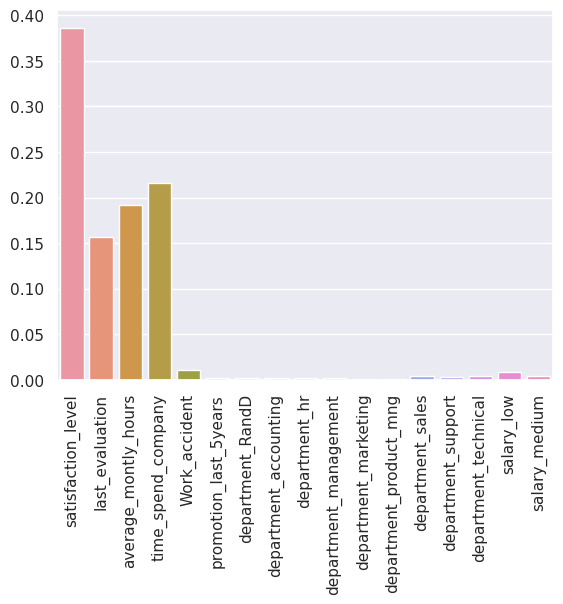

In [44]:
x_values = list(range(len(importances)))
sns.barplot(x=x_values, y=importances)
plt.xticks(x_values, list(X.columns), rotation='vertical')

Text(0.5, 0, 'Переменные')

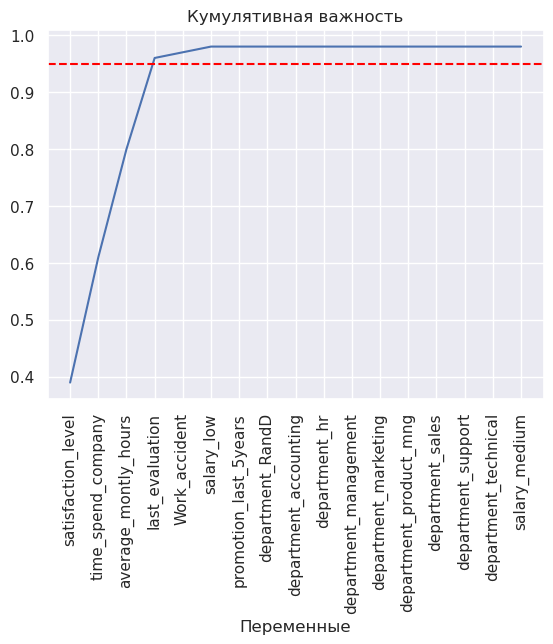

In [45]:
sorted_importances = [p[1] for p in feature_importances]
sorted_features = [p[0] for p in feature_importances]
cumulative_imp = np.cumsum(sorted_importances)
plt.plot(x_values, cumulative_imp)
plt.axhline(y=0.95, linestyle='--',  color='red')
plt.xticks(x_values, sorted_features, rotation='vertical')
plt.title('Кумулятивная важность')
plt.xlabel('Переменные')

Для принятия решения в этой модели важное значение имеют только колонки с уровнем удовлетворенности, время в компании,  среднее число часов в месяц. 

In [46]:
accuracy  = np.trace(cm2) / float(np.sum(cm2))
precision = cm2[1,1] / sum(cm2[:,1])
recall    = cm2[1,1] / sum(cm2[1,:])
f1_score  = 2*precision*recall / (precision + recall)

rf_results = pd.DataFrame({"accuracy":[accuracy],  "precision":[precision], 
                            "recall":[recall],  "f1_score":[f1_score]},
                           index=['rf'])


rf_results

,accuracy,precision,recall,f1_score
rf,0.990133,0.99148,0.969792,0.980516


## XGBoost (3-я модель)

In [47]:
import xgboost as xgb

In [48]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', seed=123)
xgb_model.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.995199573295404

In [49]:
xgb_model.score(X_test, y_test)

0.9850666666666666

In [50]:
#Раунд 1

params = {
    'max_depth': [3, 6, 9],
    'learning_rate' : [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
    
}

gc_gxb = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', seed=123, subsample=0.9, 
                      colsample_bytree=0.5), 
                      param_grid=params,
                      cv=3, 
                      scoring='accuracy',
                      verbose=1
                      )
gc_gxb.fit(X_train, y_train)
print(gc_gxb.best_score_)
print(gc_gxb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.9832875374173854
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}


In [51]:
#Раунд 2

params = {
    'max_depth': [9, 10, 11],
    'learning_rate' : [0.1],
    'n_estimators': [300, 400, 500]
    
}

gc_gxb = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', seed=123, subsample=0.9, 
                      colsample_bytree=0.5), 
                      param_grid=params,
                      cv=3, 
                      scoring='accuracy',
                      verbose=1
                      )
gc_gxb.fit(X_train, y_train)
print(gc_gxb.best_score_)
print(gc_gxb.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.9844431403929937
{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 300}


In [52]:
#Раунд 3

params = {
    'max_depth': [11, 12, 13],
    'learning_rate' : [0.1],
    'n_estimators': [300]
    
}

gc_gxb = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', seed=123, subsample=0.9, 
                      colsample_bytree=0.5), 
                      param_grid=params,
                      cv=3, 
                      scoring='accuracy',
                      verbose=1
                      )
gc_gxb.fit(X_train, y_train)
print(gc_gxb.best_score_)
print(gc_gxb.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.9844431403929937
{'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 300}


In [53]:
#Раунд 4

params = {
    'max_depth': [11],
    'learning_rate' : [0.1],
    'n_estimators': [300],
    'reg_alpha' :[0.001, 0.01, 0.1],
    'gamma' : [0, 0.3, 0.5],
    'reg_lambda': [0, 1, 10]
    
}

gc_gxb = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', seed=123, subsample=0.9, 
                      colsample_bytree=0.5), 
                      param_grid=params,
                      cv=3, 
                      scoring='accuracy',
                      verbose=1
                      )
gc_gxb.fit(X_train, y_train)
print(gc_gxb.best_score_)
print(gc_gxb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.9844431641030201
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0}


In [54]:
#Раунд 5

params = {
    'max_depth': [11],
    'learning_rate' : [0.1],
    'n_estimators': [300],
    'reg_alpha' :[0.1, 0.2, 0.3],
    'gamma' : [0.5, 0.6, 0.7],
    'reg_lambda': [0]
    
}

gc_gxb = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', seed=123, subsample=0.9, 
                      colsample_bytree=0.5), 
                      param_grid=params,
                      cv=3, 
                      scoring='accuracy',
                      verbose=1
                      )
gc_gxb.fit(X_train, y_train)
print(gc_gxb.best_score_)
print(gc_gxb.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.9844431641030201
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0}


In [55]:
# Финальная модель

xgb_model = xgb.XGBClassifier(objective='binary:logistic', 
                              seed=123, 
                              gamma= 0.5, 
                              learning_rate = 0.1, 
                              max_depth= 11, 
                              n_estimators = 300, 
                              reg_alpha = 0.1, 
                              reg_lambda =0)

xgb_model.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9980442706018313

Есть небольшое улучшение.

In [56]:
xgb_model.score(X_test, y_test)

0.9874666666666667

## Визуализация

<Axes: >

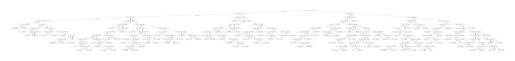

In [57]:
#Первое дерерво

xgb.plot_tree(booster=xgb_model, tree=0)

Text(0.5, 1.0, 'Важность фич для XGBoost')

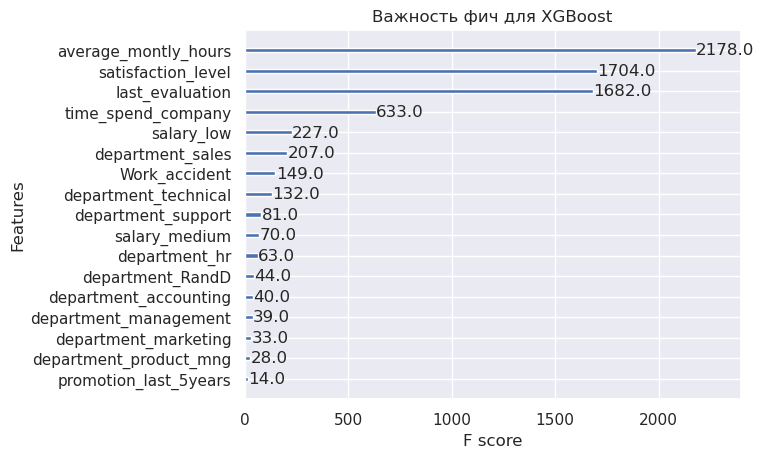

In [58]:
# Важность фич

xgb.plot_importance(booster=xgb_model)
plt.title('Важность фич для XGBoost')

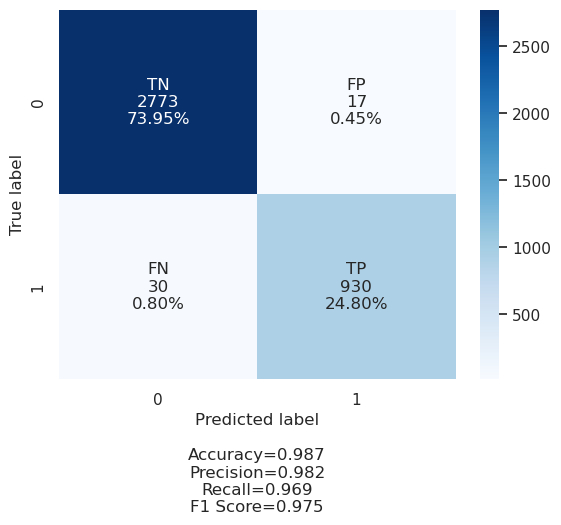

In [59]:
y_pred3 = xgb_model.predict(X_test)
cm3 = confusion_matrix(y_test, y_pred3)
make_confusion_matrix(cm3, group_names=["TN", "FP", "FN", "TP"])

In [60]:
accuracy  = np.trace(cm3) / float(np.sum(cm3))
precision = cm3[1,1] / sum(cm3[:,1])
recall    = cm3[1,1] / sum(cm3[1,:])
f1_score  = 2*precision*recall / (precision + recall)

xgb_results = pd.DataFrame({"accuracy":[accuracy],  "precision":[precision], 
                            "recall":[recall],  "f1_score":[f1_score]},
                           index=['xgboost'])


xgb_results

,accuracy,precision,recall,f1_score
xgboost,0.987467,0.982049,0.96875,0.975354


## Заключение

In [61]:
pd.concat([logreg_thr_results, rf_results, xgb_results])

,accuracy,precision,recall,f1_score
log_reg,0.760800,0.524101,0.713542,0.604323
rf,0.990133,0.991480,0.969792,0.980516
xgboost,0.987467,0.982049,0.968750,0.975354


** RandomForest** самая оптимальная модель с самымии высокими значениями и для Recall, и для Accuracy.